<a href="https://colab.research.google.com/github/drewwint/Neuroimaging-Python-Scripts/blob/main/DDC_simulation_verify_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Differnetial Covariance for Python
## Code to calcualte DDC - both linear and non-linear as well as their regularized forms in Python
## Demonstration below validates this code with a similation for timeseries signal recovery
#### Written by: Drew E. Winters, PhD.

## packages

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import os, glob, pathlib
import re # to manupulate varaibles
from sklearn.linear_model import Ridge
from numpy.linalg import inv, matrix_rank
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances


In [14]:
seed = 5489 # set seed for reproducibility
  ## according to <https://walkingrandomly.com/?p=5480> this is the same as matlab default twister 0 "rng(0)""
np.random.seed(seed)

# Functions

## Non-linear timeseries simulation function

ReLU nonlinearity
Simulation iteration: 0.10
Simulation iteration: 0.20
Simulation iteration: 0.30
Simulation iteration: 0.40
Simulation iteration: 0.50
Simulation iteration: 0.60
Simulation iteration: 0.70
Simulation iteration: 0.80
Simulation iteration: 0.90


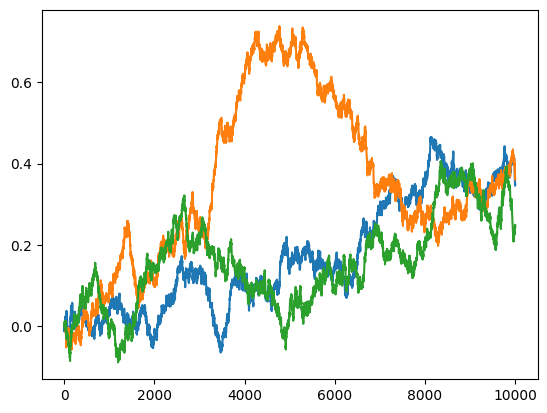

In [15]:
import numpy as np
import pandas as pd

def nonlinear_simulation(G, deltaT, RandInput, options):
    """
    Simulate the dynamics of a nonlinear system.

    Parameters:
    - G (numpy.ndarray): Connectivity matrix.
    - deltaT (float): Integration step.
    - RandInput (float): Magnitude of noisy input.
    - options (dict): Dictionary with keys 'nonlinearity', 'parameter', and 'Ttotal'.

    Returns:
    - V_pre (numpy.ndarray): Time points x variables.
    """

    def relu(x, param):
        """ReLU activation function with a given parameter."""
        Fx = x - param
        Fx[Fx < 0] = 0
        return Fx

    def sigmoid(x, param):
        """Sigmoid activation function with a given parameter."""
        return 1 / (1 + np.exp(-param * x))

    def sigmoid_sym(x, param):
        """Symmetric sigmoid activation function with a given parameter."""
        return 1 / (1 + np.exp(-param * x)) - 0.5

    # Select the nonlinearity function based on options
    if options['nonlinearity'] == 'relu':
        print('ReLU nonlinearity')
        F = lambda x: relu(x, options['parameter'])
    elif options['nonlinearity'] == 'sigmoid':
        print('Sigmoid nonlinearity')
        F = lambda x: sigmoid(x, options['parameter'])
    elif options['nonlinearity'] == 'sigmoid_sym':
        print('Sigmoid symmetric nonlinearity')
        F = lambda x: sigmoid_sym(x, options['parameter'])
    else:
        raise ValueError("Unsupported nonlinearity function")

    N = G.shape[0]
    T = int(options['Ttotal'] / deltaT)  # Number of time steps
    V_pre = np.zeros((T, N))
    I = np.zeros((T, N))

    for t in range(1, T):
        u = np.random.randn(N) * RandInput
        I[t, :] = (G @ F(V_pre[t-1, :]))  # Matrix-vector multiplication
        V_pre[t, :] = V_pre[t-1, :] + (I[t, :] + u) * deltaT

        if np.any(V_pre[t, :] > 10000):
            print('Simulation exploded')
            break

        if t % (T // 10) == 0:
            print(f'Simulation iteration: {t / T:.2f}')

    return V_pre

# Example usage
    # G = np.array([[1, 0.5, 0.5],
    #               [0.5, 1, 0.5],
    #               [0.5, 0.5, 1]])
G = np.array([[0, -0.5, -0.5],
              [-0.5, 0, 0.5],
              [-0.5, 0.5, 0]])
deltaT = 0.1 #03 #*#
RandInput = 0.04
options = {
    'nonlinearity': 'relu',  # 'sigmoid' or 'sigmoid_sym'
    'parameter': 1,
    'Ttotal': 1000
}

V_pre = nonlinear_simulation(G, deltaT, RandInput, options)

# Plotting the results
import matplotlib.pyplot as plt

plt.plot(V_pre)
plt.show()


In [104]:
pd.DataFrame(V_pre).shape

(10000, 3)

## Code for the relu estimation

### Translated from matlab code: https://github.com/yschen13/DDC/tree/main
#### Improved over prior translation: https://github.com/margotwagner/DDC/blob/main/src/py_DDC/Compute_DDC.py

In [17]:


def derivative_123(f, dm, dt):
    """
    Compute the first, second, and third derivatives of a function.
    Parameters:
    - f (numpy.ndarray): Array of function values.
    - dm (int): Parameter for the derivative calculation.
    - dt (float): Time step size.
    Returns:
    - D1 (numpy.ndarray): First derivative.
    - D2 (numpy.ndarray): Second derivative.
    - D3 (numpy.ndarray): Third derivative.
    """
    t = np.arange(1 + dm, len(f) - dm)
    # for this function to work f has to be a numpy array
    f = np.array(f)
    # D1 (First Derivative)
    D1 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            d += 1
            numerator = -((f[t - n2] * n1**3 - f[t + n2] * n1**3 -
                f[t - n1] * n2**3 + f[t + n1] * n2**3))
            denominator = (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)
            D1 += numerator / denominator
    D1 /= d

    # D2 (Second Derivative)
    D2 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            d += 1
            numerator = (f[t - n2] * n1**4 + f[t + n2] * n1**4 -
                         f[t - n1] * n2**4 - f[t + n1] * n2**4 -
                         2 * f[t] * (n1**4 - n2**4))
            denominator = (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2))
            D2 += numerator / denominator
    D2 /= d

    # D3 (Third Derivative)
    D3 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            for n3 in range(n2 + 1, dm + 1):
                d += 1
                numerator = (3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
                                  f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
                                  n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
                                        f[t + n2] * (n1**5 - n1 * n3**4) +
                                        f[t - n2] * (-n1**5 + n1 * n3**4))))
                denominator = (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2))
                D3 += numerator / denominator

    D3 /= d
    return D1, D2, D3



def dCov_numerical(cx, h, dm=4):
  """
  Compute various numerical differential covariance matrices using different finite difference methods (derivative approximations).

  Parameters:
  - cx (numpy.ndarray): Time series data matrix (T x N).
  - h (float): Step size for numerical differentiation.
  - dm (int, optional): Maximum window size for custom derivative computation. Default is 4.

  Returns:
  - dCov1 (numpy.ndarray): Differential covariance using first difference method (N x N) [approximation of first derivatie].
  - dCov2 (numpy.ndarray): Differential covariance using central difference method (N x N) [approximation of second derivative].
  - dCov5 (numpy.ndarray): Differential covariance using a higher-order difference method (N x N) [approximation of five-point stencil approximation].
  - dCov_center (numpy.ndarray): Differential covariance using a custom centered method (N x N) [the centered derivative from Taylor expansion].

  NOTE:
  	dCov = <dv/dt,v>
  	covariance is computed through np.cov()
  """
  T, N = cx.shape
  # Compute first-order derivative
  cx = np.array(cx)
  diff_cx = np.vstack(((cx[1:, :] - cx[:-1, :]) / h,
                       np.mean(cx[1:, :] - cx[:-1, :], axis=0)))
  Csample = np.cov(np.hstack((diff_cx, cx)).T, rowvar=False)
  dCov1 = zscore(Csample[:N, N:N + N])

  # Compute second-order derivative
  diff_cx = np.vstack(((1/2 * cx[2:, :] - 1/2 * cx[:-2, :]) / h,
                       np.mean(1/2 * cx[2:, :] - 1/2 * cx[:-2, :], axis=0),
                       diff_cx[-1, :]))
  Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
  dCov2 = zscore(Csample[:N, N:N + N])

  # Compute five-point stencil derivative
  diff_cx = np.zeros((T, N))
  for i in range(2, T - 2):
      for j in range(2, N - 2):
        diff_cx[i, j] = (
            -cx[i + 2, j] + 8 * cx[i + 1, j]
            - 8 * cx[i - 1, j] + cx[i - 2, j]
        ) / 12.0
  Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
  dCov5 = Csample[:N, N:N + N]

  # Compute centered derivative using derivative_123
  diff_cx = np.zeros(((T - 2 * dm)-1, N))
  for i in range(N):
      dx, _, _ = derivative_123(cx[:, i], dm, h)
      diff_cx[:, i] = dx
  cx_trunc = cx[1+dm:T - dm, :]
  Csample = np.cov(np.hstack((diff_cx, cx_trunc)), rowvar=False)
  dCov_center = Csample[:N, N:N + N]

  return dCov1, dCov2, dCov5, dCov_center


def estimators(V, thres, TR):
  """
	INPUT:
  		V_obs: time points x variables
  		thres: Relu offset
  		TR: sampling interval (seconds)
  OUTPUT:
  		B: ReLu(x),x
  		dCov: dx/dt,x
  """
  T, N = V.shape
  V_obs = zscore(V, axis=0)
  Cov = np.cov(V_obs, rowvar=False)
  precision = np.linalg.inv(Cov)
  # ReLU transformation
  Fx = np.maximum(V_obs - thres, 0)
  B = np.cov(Fx,rowvar=False)
  dV = np.diff(V_obs) / TR
  dV = np.vstack([np.mean(dV, axis=0), dV[1:-1], np.mean(dV, axis=0)])
  dCov = np.cov(np.hstack([dV, V_obs]), rowvar=False)

  return Cov, precision, B, dCov


import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import zscore

def dCov_linear_Reg(V, TR, lambda_=0.01):
    """
    L2 Regularized version of deltaL.

    Parameters:
    - V (numpy.ndarray): Time series data (T x N).
    - TR (float): Sampling interval.
    - lambda_ (float): Regularization strength.

    Returns:
    - Delta_L (numpy.ndarray): Linear DDC with ridge regularization.
    """
    T, N = V.shape

    # Standardize V
    V_obs = zscore(V, axis=0)

    # Calculate numerical derivatives and estimators
    _, dCov2, _, _ = dCov_numerical(V_obs, TR)
    Cov, _, _, _ = estimators(V_obs, 0, TR)

    # Use Cov for B as per the MATLAB code
    B = Cov
    C = dCov2

    # Initialize the output matrix
    Delta_L = np.zeros_like(C)

    # Perform ridge regression for each row of C
    BtB = B.T @ B
    identity = np.eye(B.shape[1])
    BtB_reg = BtB + lambda_ * identity
    BtB_reg_inv = np.linalg.inv(BtB_reg)
    Delta_L = zscore(np.flipud((BtB_reg_inv @ B.T @ C.T).T))/2

    return Delta_L


def dcov_relu(V, TR, lambda_=0.01):
    """
    Regularized version of Delta_ReLU
    INPUT:
        V: time series
        TR: sampling interval
        lambda_: regularization strength
    OUTPUT:
        Delta_ReLU: nonlinear DDC with ReLU nonlinearity
    """
    T, N = V.shape

    # Standardize V
    V_obs = zscore(V, axis=0)
    # V_obs = V

    # Calculate numerical derivatives and estimators
    _, dCov2, _, _ = dCov_numerical(V_obs, TR)

    # Apply ReLU non-linearity to the standardized observations
    V_relu = np.maximum(V_obs, 0)  # Applying ReLU

    # Re-compute the estimators using ReLU-transformed data
    Cov, _, B, _ = estimators(V_relu, 1, TR)

    # Ridge regression using the ReLU-transformed covariance matrix
    BtB = B.T @ B
    identity = np.eye(B.shape[1])
    BtB_reg = BtB + lambda_ * identity
    BtB_reg_inv = np.linalg.inv(BtB_reg)
    Delta_ReLU = zscore(np.flipud((BtB_reg_inv @ B.T @ dCov2.T).T))/2

    return Delta_ReLU



# Testing the estimation by trying to recover ground truth

## Ground truth figure we are trying to recover


<Axes: >

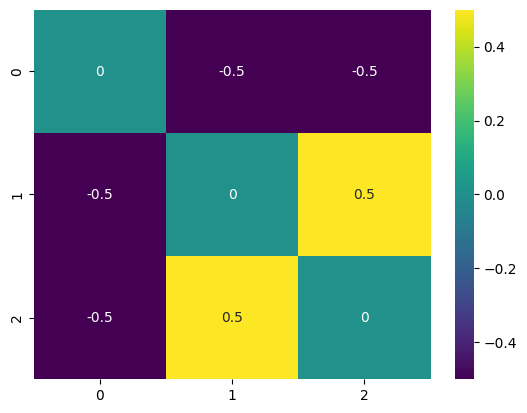

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
np.fill_diagonal(G,0)
sns.heatmap(G, annot=True, cmap = 'viridis', vmin=-0.5, vmax=0.5)

## Correlation Recovery

<Axes: >

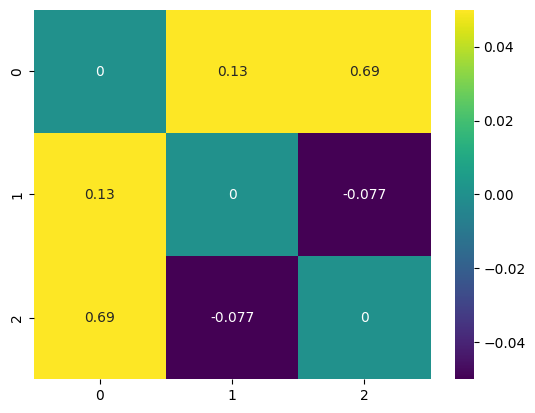

In [22]:
cor = pd.DataFrame(V_pre).corr()
np.fill_diagonal(cor.values,0)
sns.heatmap(cor, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

### Delta L Recovery

In [87]:
dCov1, dCov2,_,dCovC = dCov_numerical(V_pre, deltaT)
Cov,Precision,B,_ = estimators(V_pre, np.percentile(V_pre,50), deltaT)

<Axes: >

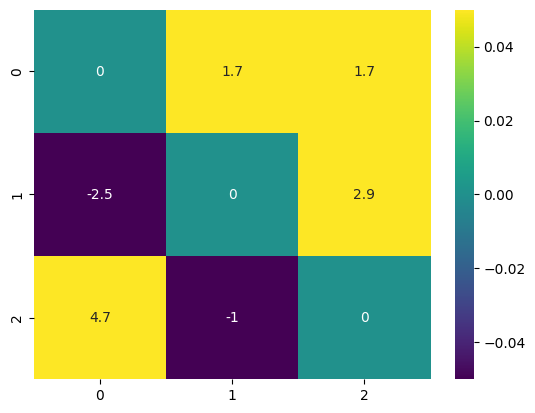

In [91]:
delta_l = np.matmul(dCov2,Precision)
delta_l_p = delta_l.copy()
np.fill_diagonal(delta_l_p,0)
sns.heatmap(delta_l_p, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)


### Delta Relu Recovery

<Axes: >

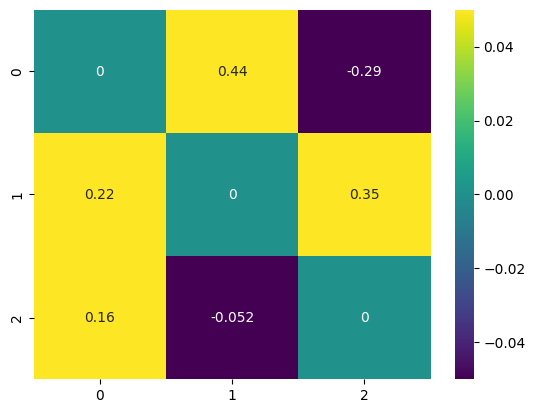

In [90]:
# delta_relu = np.matmul(dCovC,B)
# delta_relu_p = zscore(delta_relu.copy())
delta_relu = np.matmul(dCov2,B)
delta_relu_p = delta_relu.copy()
np.fill_diagonal(delta_relu_p,0)
sns.heatmap(delta_relu_p, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

## non-linearn ddc estimation
* ddc_relu = regularized non-linear

In [19]:
ddc_relu = dcov_relu(V=V_pre, TR=deltaT)

In [ ]:
ddc_relu

array([[ 0.69068468, -0.34784253, -0.68810007],
       [-0.21413259, -0.35923367,  0.48507739],
       [-0.4765521 ,  0.7070762 ,  0.20302268]])

In [20]:
ddc_relu = dcov_relu(V=V_pre, TR=deltaT)
ddc_relu

array([[ 0.69068468, -0.34784253, -0.68810007],
       [-0.21413259, -0.35923367,  0.48507739],
       [-0.4765521 ,  0.7070762 ,  0.20302268]])

### what we recovered - regularized non-linear (relu)

<Axes: >

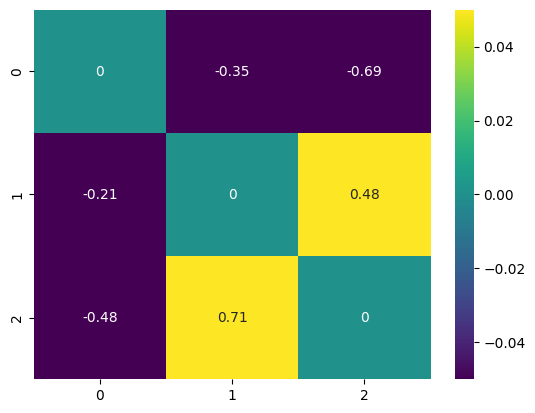

In [21]:
ddc_relu_p = ddc_relu.copy()
np.fill_diagonal(ddc_relu_p,0)
sns.heatmap(np.round(ddc_relu_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

## Linear DDC Estimation
ddc_l = linear regularized ddc


In [23]:
ddc_l = dCov_linear_Reg(V_pre, TR=0.1)

<Axes: >

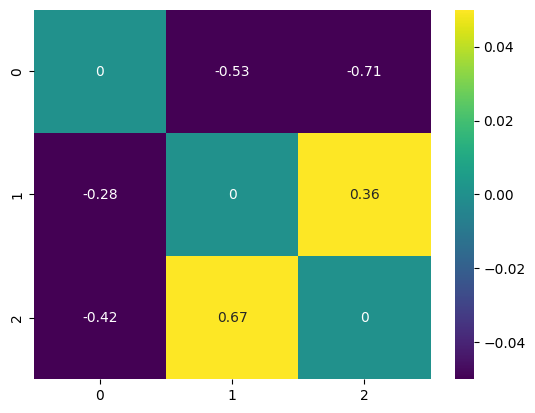

In [24]:
ddc_l_p = ddc_l.copy()
np.fill_diagonal(ddc_l_p,0)
sns.heatmap(ddc_l_p, annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)

# Evaluating recovery

## Representational similarity function to evaluate recovery

In [36]:
from joblib import parallel_backend

def distance(m1,m2):
  distance = []
  d_norm = []
  import numpy as np
  if len(m1) == len(m2) and m1[0].shape == m2[0].shape:
    for m in range(len(m1)):
      print("Calculating distance for pair", 1+m, "/", len(m1))
      mm = np.zeros([m1[m].shape[0],m1[m].shape[1]])
      for i in range(len(m1[m])):
        for j in range(len(m1[m][i])):
          mm[i][j] = (np.linalg.norm(m2[m][i][j] - m1[m][i][j]))
      distance.append(mm)
    for m in distance:
      mm2 = np.zeros([m.shape[1],m.shape[1]])
      for i in range(len(m)):
        for j in range(len(m[i])):
          mm2[i][j] = ((m[i][j]-np.min(m))/(np.max(m) - np.min(m)))
      d_norm.append(mm2)
    return(d_norm)
  else:
    raise Warning("list are different lengths or matricies are different sizes - please fix")



# function for converting distance to similarity matricies
def dist_to_sim(d_norm):
  sim = []
  for m in d_norm:
    print("Calculating similarity for", 1+len(sim), "/", len(d_norm))
    mm = np.zeros([m.shape[0],m.shape[1]])
    for i in range(len(m)):
      for j in range(len(m[i])):
        mm[i][j] = (((np.max(np.array(m))-np.min(np.array(m)))/2) - m[i][j])
    sim.append(mm)
  return(sim)



### Demonstrating representational similarity output


#### Very similar matrix

In [62]:
GG = np.array([[0, 0.5, 0.5],
              [0.5, 0, 0.5],
              [0.5, 0.5, 0]])
GG2 = np.array([[0, 0.5, 0.35],
              [0.45, 0, 0.5],
              [0.5, 0.5, 0]])
dist_G = distance([GG],[GG2])
sim_G = dist_to_sim(dist_G)
print("\n Similarity Matrix \n", pd.DataFrame(sim_G[0]))
print("\n Average Similarity = ", round(np.average(sim_G[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0    1    2
0  0.500000  0.5 -0.5
1  0.166667  0.5  0.5
2  0.500000  0.5  0.5

 Average Similarity =  0.352

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


#### Very different matrix

In [74]:
GG = np.array([[0, 0.5, 0.5],
              [0.5, 0, 0.5],
              [0.5, 0.5, 0]])
GG2 = np.array([[0.2, -0.5, -0.35],
              [-0.45, 0.1, -0.5],
              [-0.5, -0.5, 0.7]])
dist_G = distance([GG],[GG2])
sim_G = dist_to_sim(dist_G)
print("\n Similarity Matrix \n", pd.DataFrame(sim_G[0]))
print("\n Average Similarity = ", round(np.average(sim_G[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0    1         2
0  0.388889 -0.5 -0.333333
1 -0.444444  0.5 -0.500000
2 -0.500000 -0.5 -0.166667

 Average Similarity =  -0.228

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Calculating Similarity for each matrix

In [42]:
G

array([[ 0. , -0.5, -0.5],
       [-0.5,  0. ,  0.5],
       [-0.5,  0.5,  0. ]])

#### Correlation similarity

In [77]:
dist_cor = distance([cor],[G])
sim_cor = dist_to_sim(dist_cor)
print("\n Similarity Matrix \n", pd.DataFrame(sim_cor[0]))
print("\n Average Similarity= ", round(np.average(sim_cor[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.500000 -0.033771 -0.500000
1 -0.033771  0.500000  0.014921
2 -0.500000  0.014921  0.500000

 Average Similarity=  0.051

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Delta Relu

In [93]:
dist_ddr = distance([delta_relu],[G])
sim_ddr = dist_to_sim(dist_ddr)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddr[0]))
print("\n Average Similarity = ", round(np.average(sim_ddr[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.135466 -0.500000  0.332406
1 -0.243452  0.121710  0.396345
2 -0.184025 -0.057771  0.500000

 Average Similarity =  0.056

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


Delta L

In [94]:
dist_ddl = distance([delta_l],[G])
sim_ddl = dist_to_sim(dist_ddl)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddl[0]))
print("\n Average Similarity = ", round(np.average(sim_ddl[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.165169  0.161990  0.165737
1  0.191553  0.500000  0.110922
2 -0.500000  0.299648 -0.361000

 Average Similarity =  0.082

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Regularized Linear

In [78]:
dist_ddcl = distance([ddc_l],[G])
sim_ddcl = dist_to_sim(dist_ddcl)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddcl[0]))
print("\n Average Similarity = ", round(np.average(sim_ddcl[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0 -0.500000  0.500000  0.238728
1  0.215275  0.342765  0.339613
2  0.435453  0.294961  0.030537

 Average Similarity =  0.211

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


#### Regularized non-linear

In [95]:
dist_ddcr = distance([ddc_relu],[G])
sim_ddcr = dist_to_sim(dist_ddcr)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddcr[0]))
print("\n Average Similarity = ", round(np.average(sim_ddcr[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0 -0.500000  0.296918  0.243730
1  0.099053 -0.009515  0.500000
2  0.487384  0.215649  0.221647

 Average Similarity =  0.173

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


## Cosine similarity to evaluate recovery

### Correlation


In [96]:
print(cosine_similarity(cor, G))
np.average(cosine_similarity(cor, G))

[[-0.82967103  0.69396182  0.1357092 ]
 [ 0.35033964 -0.96455632 -0.61421669]
 [ 0.07838651 -0.70274857 -0.78113509]]


-0.2926589462420968

### Regularized linear DDC

In [106]:
print(cosine_similarity(ddc_l_p, G))
np.average(cosine_similarity(ddc_l_p, G))

[[ 0.99016947 -0.56502117 -0.4251483 ]
 [-0.56054481  0.99157789  0.43103308]
 [-0.59706011  0.37883931  0.97589942]]


0.17997164286404382

### Regularized non-linear DDC

In [105]:
print(cosine_similarity(ddc_relu_p, G))
np.average(cosine_similarity(ddc_relu_p, G))

[[ 0.95006536 -0.63105817 -0.31900719]
 [-0.6468816   0.93244104  0.28555944]
 [-0.58636292  0.39519429  0.98155721]]


0.15127860797081005

In [101]:
print(cosine_similarity(delta_l, G))
np.average(cosine_similarity(delta_l, G))

[[-0.73695465  0.8445379   0.84832833]
 [-0.41194248  0.98472993  0.34532642]
 [ 0.59784767 -0.98742747 -0.61220448]]


0.09691568545208223

In [102]:
print(cosine_similarity(delta_relu, G))
np.average(cosine_similarity(delta_relu, G))

[[-0.16159145  0.09255642  0.89040563]
 [ 0.05110982  0.16738093 -0.7561247 ]
 [ 0.42402683 -0.86209069 -0.84241585]]


-0.11074923055766828